In [1]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch

from tqdm.auto import tqdm
from os.path import splitext

from utils.unet import UNet
from utils.dataset import FreiHANDDataset
from utils.utils import DiceLoss, plot_losses, plot_heatmaps

In [2]:
LOAD_ON = False
TRAIN_ON = False

In [3]:
import requests
import zipfile

if LOAD_ON:
    url = 'https://lmb.informatik.uni-freiburg.de/data/freihand/FreiHAND_pub_v2.zip'
    filename = 'FreiHAND_pub_v2.zip'

    response = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        f.write(response.content)

    print(f'{filename} downloaded!')

    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('FreiHAND_dataset')

    print("File unzipped successfully!")

In [4]:
import os

print(len(os.listdir(os.path.join('FreiHAND_dataset/training', 'rgb'))))

130240


In [5]:
KEYPOINTS_NUM = 21
RESIZED_IMG_SIZE = 128
MEANS = [0.3950, 0.4323, 0.2954]
STDS = [0.1966, 0.1734, 0.1836]

In [6]:
IMAGE_DIR = 'FreiHAND_dataset/training'
MODEL_PATH = 'model/m_keypoints.pth'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

BATCH_SIZE = 48
EPOCH_NUM = 150
TRAIN_RATIO = 0.8

cuda


# Training

In [7]:
def train():
    model = UNet(KEYPOINTS_NUM).to(DEVICE)

    dataset = FreiHANDDataset(IMAGE_DIR, transform=transforms.Compose([
        transforms.Resize((RESIZED_IMG_SIZE, RESIZED_IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEANS, std=STDS)
    ]))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True, drop_last=True, persistent_workers=True)
    val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True, drop_last=True, persistent_workers=True)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1)

    dice_loss = DiceLoss()

    tr_losses, val_losses = [], []

    for epoch in range(EPOCH_NUM):
        epoch_loss = 0
        prog_bar_train = tqdm(train_loader, total=50)

        model.train()
        for i, batch in enumerate(prog_bar_train):
            if i >= 50:
                break
            images, targets = batch

            images = images.to(DEVICE)
            gt_heatmaps = targets['heatmaps'].to(DEVICE)

            optimizer.zero_grad()
            heatmaps = model(images)
            loss = dice_loss(heatmaps, gt_heatmaps)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            prog_bar_train.set_description(desc=f"Loss: {loss.item():.4f}")

        val_loss = 0
        prog_bar_val = tqdm(val_loader, total=20)

        model.eval()
        with torch.no_grad():
            for i, batch in enumerate(prog_bar_val):
                if i >= 20:
                    break
                images, targets = batch

                images = images.to(DEVICE)
                gt_heatmaps = targets['heatmaps'].to(DEVICE)

                heatmaps = model(images)
                loss = dice_loss(heatmaps, gt_heatmaps)

                val_loss += loss.item()
                prog_bar_val.set_description(desc=f"ValLoss: {loss.item():.4f}")

        train_loss = epoch_loss / 50
        val_loss = val_loss / 20
        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

        tr_losses.append(train_loss)
        val_losses.append(val_loss)

        scheduler.step(train_loss)

        if epoch != 0 and epoch % 5 == 0:
            torch.save(model.state_dict(), splitext(MODEL_PATH)[0] + '_' + str(epoch+1) + '.pth')

    torch.save(model.state_dict(), MODEL_PATH)
    plot_losses(tr_losses, val_losses, 'Losses.png')

In [8]:
if TRAIN_ON:
    train()

# Evaluation

In [9]:
import math
import matplotlib.pyplot as plt
import numpy as np


def plot_results(targets, heatmaps, resized_img_size, filename):
    pred_keypoints = torch.argmax(torch.flatten(heatmaps, start_dim=2), dim=2)
    # find exact location
    pred_keypoints_y = pred_keypoints.float() // resized_img_size
    pred_keypoints_x = pred_keypoints.float() - resized_img_size * pred_keypoints_y

    # normalize positions
    pred_keypoints_x /= resized_img_size
    pred_keypoints_y /= resized_img_size

    num_images = len(heatmaps)
    _, axes = plt.subplots(math.ceil(num_images / 5), 5, figsize=(15, 10))
    axes = list(axes)
    for i in range(num_images):
        img_size = np.array(targets['img_size'])[:, i]
        img_org = targets['original'][i]

        image = np.array(img_org)
        image = image.transpose((1, 2, 0))

        keypoints_x = pred_keypoints_x[i] * img_size[0]
        keypoints_y = pred_keypoints_y[i] * img_size[1]

        axes[i // 5][i % 5].imshow(image)
        axes[i // 5][i % 5].scatter(keypoints_x.int(), keypoints_y.int(), s=10, marker='.', c='r')
        axes[i // 5][i % 5].axis('off')
    plt.tight_layout()
    plt.savefig('figures/' + filename)

In [10]:
model = UNet(KEYPOINTS_NUM).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

dataset = FreiHANDDataset(IMAGE_DIR, transform=transforms.Compose([
    transforms.Resize((RESIZED_IMG_SIZE, RESIZED_IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEANS, std=STDS)
]))

loader = DataLoader(dataset, batch_size=15, num_workers=2, shuffle=True)

C:\Users\sveta\AppData\Local\Temp\ipykernel_6292\3689076526.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


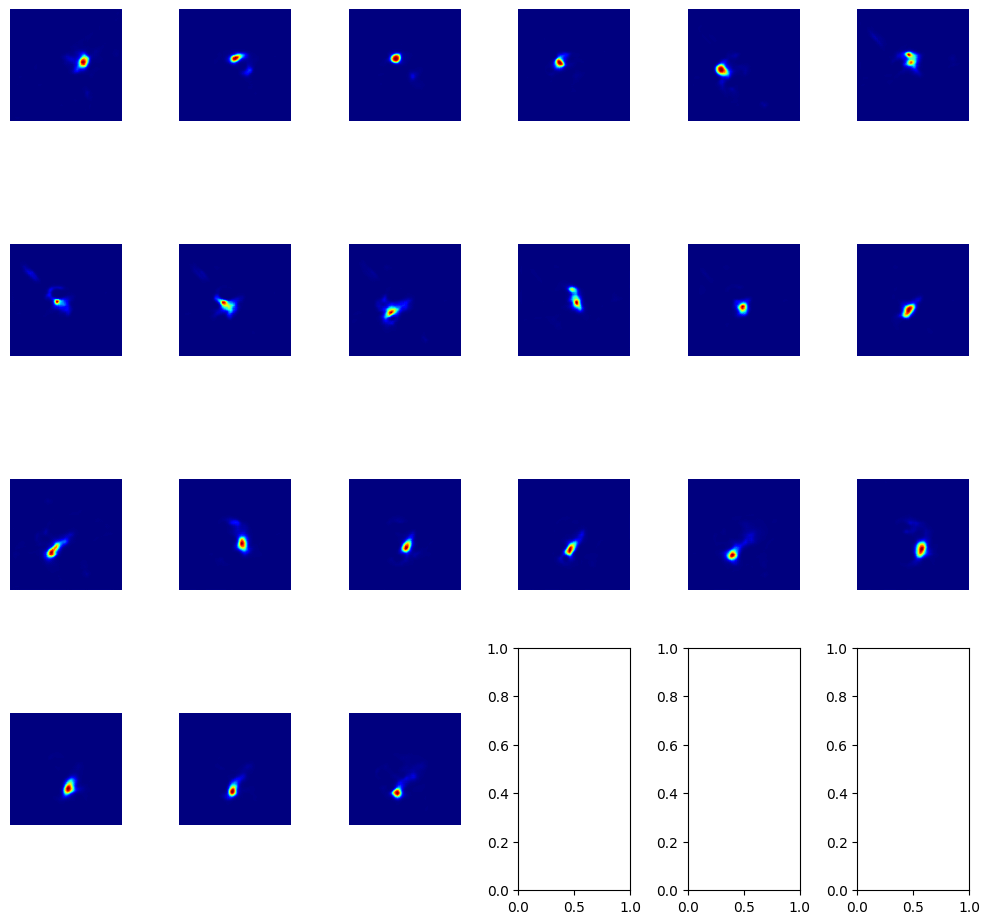

In [11]:
with torch.no_grad():
    for i, batch in enumerate(loader):
        images, targets = batch
        images = images.to(DEVICE)

        heatmaps = model(images).cpu()
        plot_heatmaps(heatmaps[0], 'Result_Heatmap.png')
        # plot_results(targets, heatmaps, RESIZED_IMG_SIZE, 'Results.png')
        break
